In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos


In [2]:
from pathlib import Path
import pickle
import pandas as pd
from src.classical.classical_approach import load_data
from src.subsampling.subsample import fix_torus, aggregate_velocities, recenter
from src.pipeline.pipeline import *
from jax import numpy as jnp
import jax
from src.summarize.oat import oat_validate_knn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.gw.lower_bounds import second

In [3]:
root_path = Path(".")
data_path = root_path / "data"
gen_data_path = root_path / "generated_data_big"

features_and_targets = jnp.load(gen_data_path / "features_and_targets.npz")
subsampled_data = jnp.load(gen_data_path / "kmeans_subsampled_n2_s75.npz")

n_halos = 1_000
prop_train = 0.75
prop_test = 0.25

n_train = int(n_halos * prop_train)
n_test = n_halos - n_train

rng = jax.random.PRNGKey(0)

train_indices = jax.random.choice(rng, n_halos, [n_train], replace=False)
test_indices = jnp.array(
    list(set(range(n_halos)) - set([ix.item() for ix in list(train_indices)]))
)
np.savetxt(gen_data_path / "train_indices.txt", np.array(train_indices), fmt="%i")
np.savetxt(gen_data_path / "test_indices.txt", np.array(test_indices), fmt="%i")

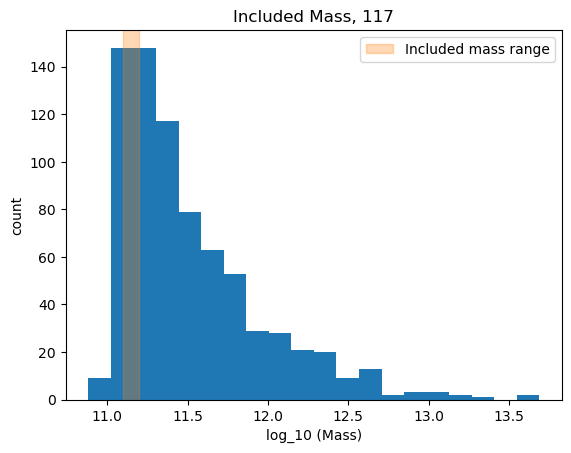

In [37]:
# We'll include mass-slicing so that we can go back to a thin slice if necessary:
mass_range = (11.1, 11.2)  # set to (-np.inf, np.inf) to include everything
train_log_m = np.log10(features_and_targets["mass"][train_indices])
train_sliced_mass_ix = train_indices[
    np.argwhere((train_log_m > mass_range[0]) & (train_log_m < mass_range[1]))[:, 0]
]
fig, ax = plt.subplots()
ax.hist(train_log_m, bins=20)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.axvline(mass_range[1], c='r')
ax.fill_betweenx(
    y=[-1, 1e6],
    x1=[mass_range[1], mass_range[1]],
    x2=[mass_range[0], mass_range[0]],
    color="C1",
    alpha=0.3,
    label="Included mass range"
)
ax.set(xlim=xlim, ylim=ylim, title=f"Included Mass, {len(train_sliced_mass_ix)}", xlabel="log_10 (Mass)", ylabel="count")
ax.legend()

In [38]:
t = 0
weights_subsampled = subsampled_data["weights"][train_sliced_mass_ix, t]
points_subsampled = subsampled_data["points"][train_sliced_mass_ix, t]
velocities_subsampled = subsampled_data["velocities"][train_sliced_mass_ix, t]

train_stellar_mass = features_and_targets["stellar_mass"][train_sliced_mass_ix]
train_labels = jnp.log10(train_stellar_mass * 1e10 / 0.677)  # label by logMstar
train_concentration = features_and_targets["concentration"][train_sliced_mass_ix]
train_mass = jnp.log10(features_and_targets["mass"][train_sliced_mass_ix])

problem_context = ProblemContext(
    points = points_subsampled,
    weights=weights_subsampled,
    velocities=velocities_subsampled,
    masses=train_mass,
    concentrations=train_concentration,
    labels=jnp.log10(train_stellar_mass * 1e10 / 0.677),  # label by logMstar (I don't know what this comment means -Dan)
)


In [53]:
n_p, n_q = 10, 10
hyperparametrization = Hyperparametrization(
    rescale_strategy=["none"],
    p = np.logspace(-1, 0, base=10, num=n_p),
    q=np.logspace(-1, 0, base=10, num=n_q),
    tau=1.0,
    alpha_C=np.logspace(-2.0, 2.0, num=12, base=10, endpoint=True),
    alpha_M=0.0,
    alpha_SLB=np.logspace(-2.0, 2.0, num=10, base=10, endpoint=True),
    n_neighbors=np.arange(0, 40)
)

losses = get_losses(problem_context, hyperparametrization)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: >

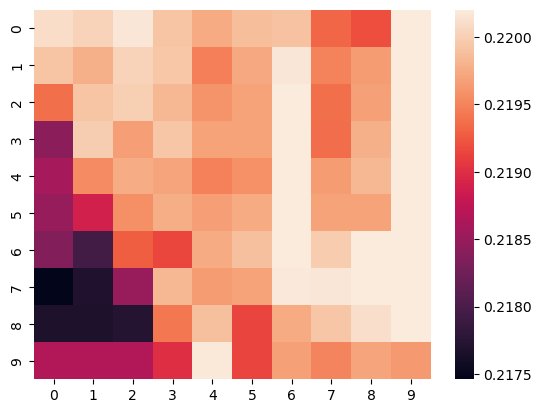

In [54]:
loss_vals = [loss["loss"] for loss in losses]
best_ixs = np.argsort(loss_vals)
sorted_losses = [losses[ix] for ix in best_ixs]
sorted_losses[:5]
loss_array = np.array(loss_vals).reshape(n_p, n_q, 12, 10, 40)
# plt.plot()
import seaborn as sns
sns.heatmap(np.min(loss_array[:, :], axis=(2, 3, 4)))
# plt.plot(loss_array[0, 9, 1:])
# plt.plot(loss_array[9, 0, 1:])
# plt.plot(loss_array[9, 9, 1:])

In [70]:
t = 0
weights_subsampled = subsampled_data["weights"][sliced_mass_ix, t]
points_subsampled = subsampled_data["points"][sliced_mass_ix, t]
velocities_subsampled = subsampled_data["velocities"][sliced_mass_ix, t]
p, q = 3, 0.5

dispersion = lambda pts: jnp.sqrt(jnp.trace(jnp.cov(pts.T)))




tau = 1.0
phase_subsampled = jnp.concatenate(
    [points_subsampled, tau * velocities_subsampled], axis=-1
)

slb_phase_dists = batched_slb_func(p, q, batch_size=15, pbar=True)(
    phase_subsampled, phase_subsampled, weights_subsampled, weights_subsampled
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [78]:

train_stellar_mass = features_and_targets["stellar_mass"][sliced_mass_ix]
train_labels = jnp.log10(train_stellar_mass * 1e10 / 0.677)  # label by logMstar
train_concentration = features_and_targets["concentration"][sliced_mass_ix]
train_mass = jnp.log10(features_and_targets["mass"][sliced_mass_ix])

train_concentration_dists = jnp.abs(train_concentration[:, None] - train_concentration[None, :])
train_mass_dists = jnp.abs(train_mass[:, None] - train_mass[None, :])
train_slb_phase_dists = slb_phase_dists[train_indices][:, train_indices]



alphas = jnp.array([1.0, 1.0, 1.0, ])

blended_dists = combine_dists(alphas, [train_concentration_dists, train_mass_dists, slb_phase_dists])

print(
    f"Blended loss {alphas}: {oat_validate_knn(blended_dists, train_labels, k=5, weighting="uniform"):.2f}"
)

Blended loss [1. 1. 1.]: 0.18


In [79]:
# plt.scatter(train_slb_phase_dists.flatten(), train_mass_dists.flatten())
# plt.hist(train_mass_dists.flatten())
jnp.max(train_slb_phase_dists)

Array(14938.915, dtype=float32)

In [92]:
from itertools import product

alpha_ms = np.logspace(-1, 2, num=10)
alpha_SLBs = np.logspace(-1, 2, num=15)
losses = np.zeros([alpha_ms.shape[0], alpha_SLBs.shape[0]])

for (m_ix, alpha_m), (SLB_ix, alpha_SLB) in tqdm(
    list(product(enumerate(alpha_ms), enumerate(alpha_SLBs)))
):
    blended_dists = combine_dists(
        jnp.array([1.0, alpha_m, alpha_SLB]),
        [train_concentration_dists, train_mass_dists, slb_phase_dists],
    )
    losses[m_ix, SLB_ix] = oat_validate_knn(
        blended_dists, train_labels, k=5, weighting="uniform"
    )
    # alphas = jnp.array([1.0, 1.0, 1.0])

  0%|          | 0/150 [00:00<?, ?it/s]

[Text(0.5, 80.7222222222222, '$\\alpha_{SLB}$'),
 Text(145.72222222222223, 0.5, '$\\alpha_{m}$')]

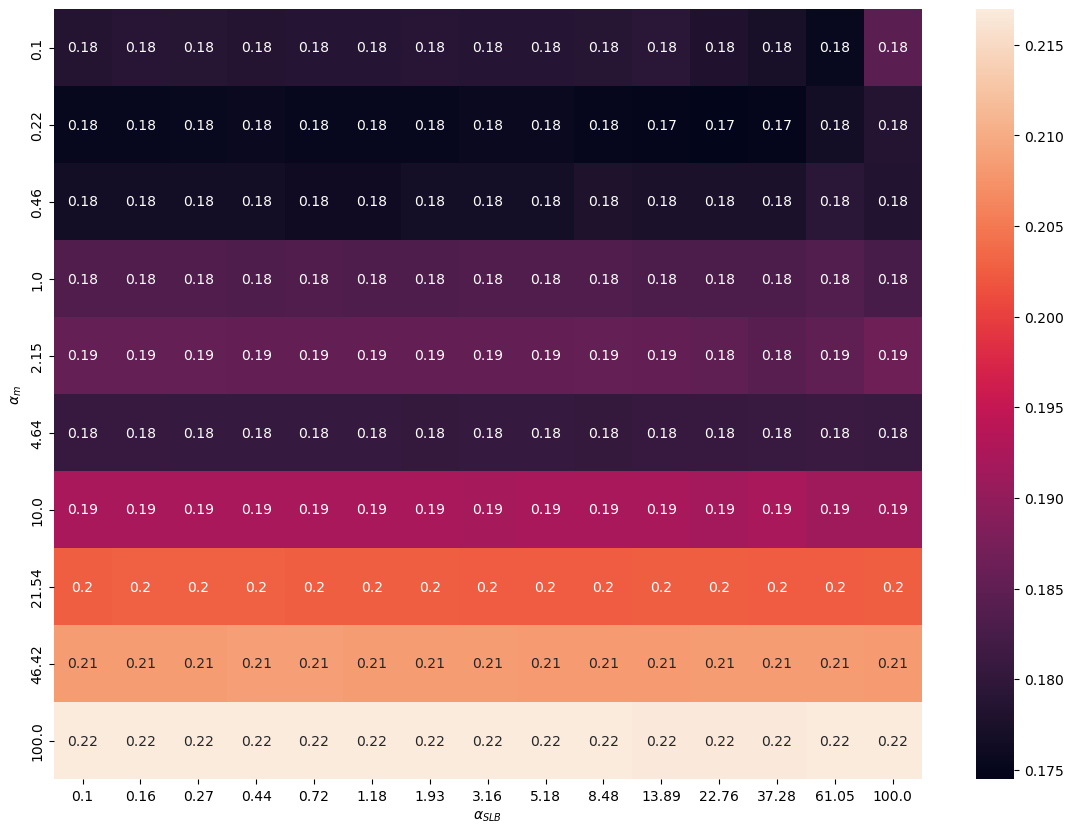

In [93]:
losses_df = pd.DataFrame(losses, index=np.round(alpha_ms, 2), columns=np.round(alpha_SLBs, 2))
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(losses_df, annot=True)
ax.set(xlabel=r"$\alpha_{SLB}$", ylabel=r"$\alpha_{m}$")
# losses_df

In [96]:
alpha_SLBs = np.logspace(-1, 2, num=100)
losses = np.zeros([alpha_SLBs.shape[0]])

for SLB_ix, alpha_SLB in tqdm(list(enumerate(alpha_SLBs))):
    blended_dists = combine_dists(
        jnp.array([1.0, 10., alpha_SLB]),
        [train_concentration_dists, train_mass_dists, slb_phase_dists],
    )
    losses[SLB_ix] = oat_validate_knn(
        blended_dists, train_labels, k=5, weighting="uniform"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

[None]

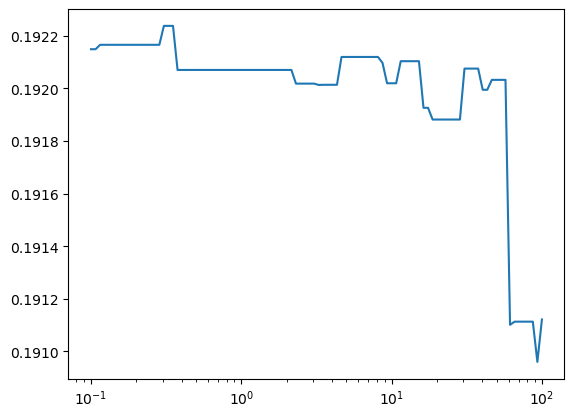

In [97]:
fig, ax = plt.subplots()
plt.plot(alpha_SLBs, losses)
ax.set(xscale="log")

In [42]:
alpha_Cs = np.logspace(-1, 2, num=100)
losses = np.zeros([alpha_Cs.shape[0]])

for C_ix, alpha_C in tqdm(list(enumerate(alpha_Cs))):
    blended_dists = combine_dists(
        jnp.array([alpha_C, 10., 1.0]),
        [train_concentration_dists, train_mass_dists, train_slb_phase_dists],
    )
    losses[C_ix] = oat_validate_knn(
        blended_dists, train_labels, k=8, weighting="uniform"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

[None]

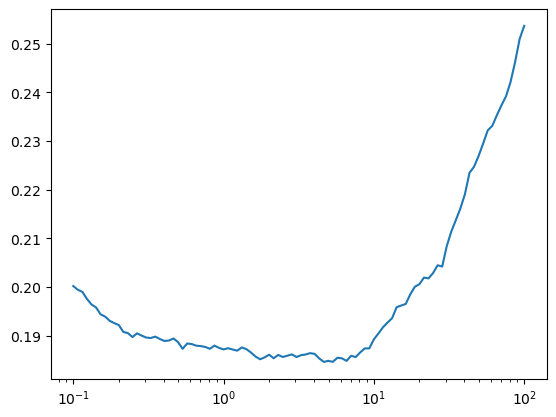

In [44]:
fig, ax = plt.subplots()
ax.plot(alpha_Cs, losses)
ax.set(xscale="log")

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

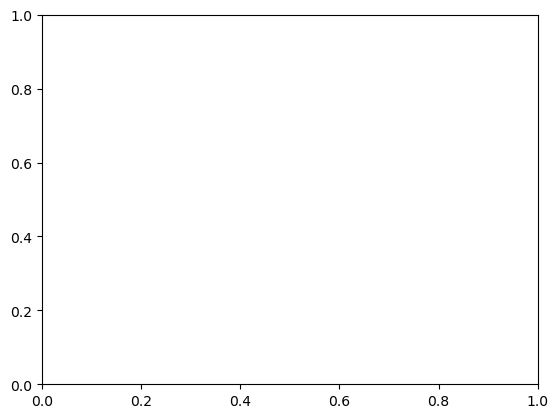

In [54]:
fig, ax = plt.subplots()
ax.plot(alpha_ms, losses)
ax.set(xscale="log")

  0%|          | 0/50 [00:00<?, ?it/s]

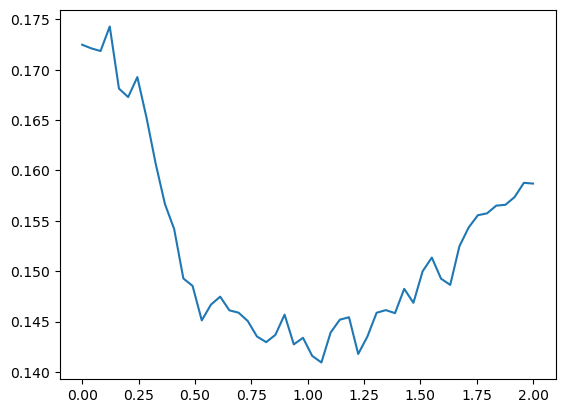

In [14]:
# Compute SLB in phase space
labels = jnp.log10(properties["GroupStellarMass"] * 1e10 / 0.677)  # label by logMstar
phi_s = np.linspace(0.0, 2.0)  # Conversion from velocities to coordinates, units of time
losses = []
for alpha in tqdm(phi_s):
    k = 5
    weighting = "inverse_sqrt"

    phase_subsampled = jnp.concatenate(
        [points_subsampled, alpha * velocities_subsampled], axis=-1
    )
    slb_phase_dists = slb_func(p, q)(
        phase_subsampled[:, t],
        phase_subsampled[:, t],
        weights_subsampled[:, t],
        weights_subsampled[:, t],
    )
    losses.append(oat_validate_knn(slb_phase_dists, labels, k, weighting).item())

plt.plot(phi_s, losses)

In [39]:
from itertools import product

n_p, n_q = 10, 10
ps = np.linspace(0.5, 5, num=n_p)
qs = np.linspace(0.1, 2, num=n_q)
phi = 1.0

loss_matrix = np.zeros([n_p, n_q])

for (p_ix, p), (q_ix, q) in tqdm(list(product(enumerate(ps), enumerate(qs)))):
    slb_phase_dists = slb_func(p, q)(
        phase_subsampled[:, t],
        phase_subsampled[:, t],
        weights_subsampled[:, t],
        weights_subsampled[:, t],
    )
    loss_matrix[p_ix, q_ix] = oat_validate_knn(
        slb_phase_dists, labels, k, weighting
    ).item()

  0%|          | 0/100 [00:00<?, ?it/s]

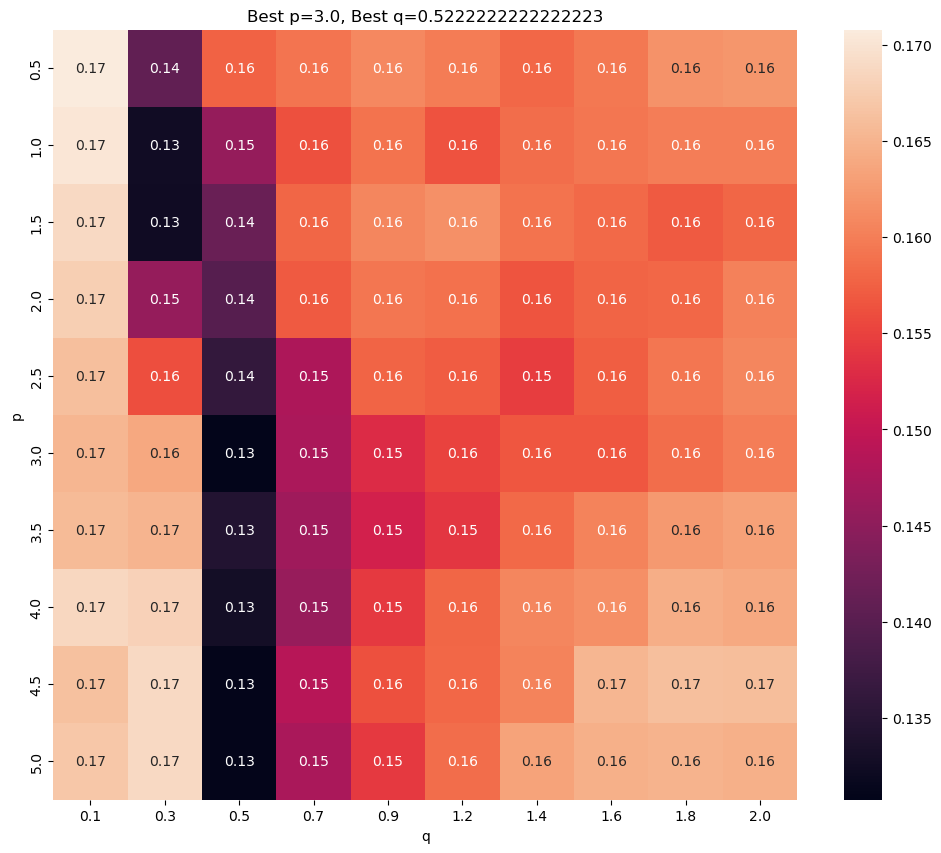

In [43]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 10))
loss_df = pd.DataFrame(loss_matrix, index=np.round(ps, 1), columns=np.round(qs, 1))
sns.heatmap(loss_df, annot=True, ax=ax)

best_p_ix, best_q_ix = np.unravel_index(np.argmin(loss_matrix), loss_matrix.shape)
best_p, best_q = ps[best_p_ix], qs[best_q_ix]

ax.set(xlabel="q", ylabel="p", title=f"Best p={best_p}, Best q={best_q}");